**Навигация по уроку**

1. [Telegram бот c ChatGPT на борту. Знакомство с  ChatGPT](https://colab.research.google.com/drive/1tqXt0XNstMb2TeJ8Za9S2xQA6ipjyMPk)
2. [Подготовка данных для обучения chatGPT методом Search-Ask (Практика)](https://colab.research.google.com/drive/1GmRiwmUH8E8KJ4d1g8vDVMGSdfmFFjd5)
3. Домашняя работа

Используя знания из [первой части](https://colab.research.google.com/drive/1tqXt0XNstMb2TeJ8Za9S2xQA6ipjyMPk) урока, а также базы знаний, полученной в [практической части](https://colab.research.google.com/drive/1GmRiwmUH8E8KJ4d1g8vDVMGSdfmFFjd5) урока, создайте телеграм-бот, который будет отвечать на вопросы из вашей базы знаний. Для создания телеграм-бота используйте библиотеку aiogram3. При отправке Telegram-боту команды `/help` он должен возвращать информацию о базе знаний: тематика, число записей в базе знаний, пример запроса к базе. Задание выполните в Блокноте, для этого вам необходимо вспомнить, как запустить асинхронный цикл в Google Colab.




In [ ]:
# Ваше решение

#Начнем с создания бота телеграмм

In [42]:
import os
import asyncio
from aiogram import Bot, Dispatcher, types, Router
from aiogram.filters import Command
from google.colab import userdata

# подключаем токен из секретов
API = userdata.get("GPTasExample_bot_API")

# инициализируем бота и диспетчер
bot = Bot(token=API)
router = Router()

# обработка команды /start
@router.message(Command("start"))
async def cmd_start(message: types.Message):
    await message.answer("Привет! Я тренировочная модель GPT-3.5-Turbo, дообученная на данных о развитии ИИ в 2024/2025 годах")

# обработка команды /help
@router.message(Command("help"))
async def cmd_help(message: types.Message):
    info_text = "\n".join(info)
    await message.answer("Доступные команды:\n" \
                         "/start - начать общение\n" \
                         "/prompt - примеры запросов в чате\n"
                         "/help - доступные команды и информация о базе знаний\n" \
                         f"info:\n{info_text}")

@router.message(Command("prompt"))
async def cmd_prompt(message: types.Message):
    await message.answer("Вы можете задавать вопросы о достижениях ИИ, в частности в 2024/2025 году\n\n" \
                         "Примеры:\nРасскажи о DeepSeek" \
                         "\nКакие события в области ИИ произошли в 2025 году" \
                         "\nЧем отличается GPT-4o от GPT-3.5." \
                         "\n\nБот так же способен обрабатывать общие запросы по ИИ, не обращаясь к дополнительной базе знаний")

# обрабатываем текст пользователя
@router.message()
async def handle_text(message: types.Message):
    user_text = message.text # получили текст запроса

    # передаем его в функцию обработки
    response = ask(user_text)

    if response == "I could not find an answer.":
        completion = openai.chat.completions.create(
        messages=[
            {'role': 'system', 'content': 'Вы отвечаете на общие вопросы о ИИ.'},
            {'role': 'user', 'content': user_text},
            ],
            model=GPT_MODEL,
            temperature=0,
        )
        # Извлекаем текст ответа из объекта ChatCompletion
        response = completion.choices[0].message.content
        response += "\n\nДополнительная база знаний не использовалась."
    # выводим ответ
    await message.answer(response)

# запуск бота
async def main():
    dp = Dispatcher()
    dp.include_router(router)
    await dp.start_polling(bot)

if __name__ == "__main__":
    asyncio.run(main())

ERROR:aiogram.event:Cause exception while process update id=670967041 by bot id=7815248161
BadRequestError: Error code: 400 - {'error': {'message': "'input' is a required property", 'type': 'invalid_request_error', 'param': None, 'code': None}}
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/aiogram/dispatcher/dispatcher.py", line 309, in _process_update
    response = await self.feed_update(bot, update, **kwargs)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/aiogram/dispatcher/dispatcher.py", line 158, in feed_update
    response = await self.update.wrap_outer_middleware(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/aiogram/dispatcher/middlewares/error.py", line 25, in __call__
    return await handler(event, data)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/aiogram/dispatcher/middlewares/

Здесь задается API ключ, создается экземпляр диспетчера и бота с ключом, описаны команды start и help, а так же перехват сообщения пользователя и обработка его функцией ask с последующим выводом результата от этой функции.

Далее запускается сам бот на прием новых сообщений через функцию main. Запускать его следует после выполнения всех ячеек с кодом ниже.

Функция Ask и все сопутствующие необходимые функции для обработки сообщений пользователя будут описаны ниже

#Устанавливаем нужные библиотеки для работы

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install openai Wikipedia tiktoken aiogram nest_asyncio mwclient mwparserfromhell

import nest_asyncio
nest_asyncio.apply()

#Собираем статьи для добавления в нашего бота (практика 14.2)

Для сбора и подготовки данных нам необходимо:
* Собрать все заголовки статей заданной категории статей Википедии, заходя на первый уровень вложенности статей.
* Разделить каждую статью на разделы (секции) и подразделы. Отбросить менее релевантные разделы, такие как внешние ссылки и сноски.
* Очистить текст, удалив теги ссылок, пробелы и очень короткие секции (разделы).
* Добавить заголовки и подзаголовки к тексту каждого раздела, чтобы помочь chatGPT понять контекст.

In [ ]:
# imports
import mwclient  # библиотека для работы с MediaWiki API для загрузки примеров статей Википедии
import mwparserfromhell  # Парсер для MediaWiki
import openai  # будем использовать для токинизации
import pandas as pd  # В DataFrame будем хранить базу знаний и результат токинизации базы знаний
import re  # для вырезания ссылок <ref> из статей Википедии
import tiktoken  # для подсчета токенов

# Задаем категорию и англоязычную версию Википедии для поиска
CATEGORIES = [
    "Category:2024_in_artificial_intelligence",
    "Category:2025_in_artificial_intelligence"
]

WIKI_SITE = "en.wikipedia.org"

# Соберем заголовки всех статей
def titles_from_category(
    category: mwclient.listing.Category, # Задаем типизированный параметр категории статей
    max_depth: int # Определяем глубину вложения статей
) -> set[str]:
    """Возвращает набор заголовков страниц в данной категории Википедии и ее подкатегориях."""
    titles = set() # Используем множество для хранения заголовков статей
    for cm in category.members(): # Перебираем вложенные объекты категории
        if isinstance(cm, mwclient.page.Page): # Если объект является страницей
            titles.add(cm.name) # в хранилище заголовков добавляем имя страницы
        elif isinstance(cm, mwclient.listing.Category) and max_depth > 0: # Если объект является категорией и глубина вложения не достигла максимальной
            deeper_titles = titles_from_category(cm, max_depth=max_depth - 1) # вызываем рекурсивно функцию для подкатегории
            titles.update(deeper_titles) # добавление в множество элементов из другого множества
    return titles

# Инициализация объекта MediaWiki
# WIKI_SITE ссылается на англоязычную часть Википедии
site = mwclient.Site(WIKI_SITE)
all_titles = set()
info = set()

for category_title in CATEGORIES:
    # Загрузка раздела заданной категории
    category_page = site.pages[category_title]
    # Получение множества всех заголовков категории с вложенностью на один уровень
    titles = titles_from_category(category_page, max_depth=1)
    all_titles.update(titles)
    category_info = f"{len(titles)} статей в {category_title}"
    print(f"Найдено {category_info}")
    info.add(category_info)
print(f"\nВсего собрано {len(all_titles)} уникальных статей из {len(CATEGORIES)} категорий")


Найдено 4 статей в Category:2024_in_artificial_intelligence
Найдено 7 статей в Category:2025_in_artificial_intelligence

Всего собрано 11 уникальных статей из 2 категорий


Здесь мы собираем статьи в заданных категориях переменной CATEGORIES для wiki:
- **titles_from_category** сначала создает пустой сет titles, за тем проходит по каждой ссылке, и если она является страницей статьи - помещает ее в сет titles, если это страница подкатегории - то проходит по этой странице, собирая ссылки на следующие страницы категорий, либо помещая их в titles, пока не дойдет до максимальной глубины вложенности max_depth
- далее в цикле проходим по категориям, перечисленным в `CATEGORIES` функцией `titles_from_category` и формируем общий список статей по всем категориям в сете all_titles, а так же собираем статистику в сет info

## Извлечение секций из документов
Определим секции в документах, которые менее релевантны и их можно отбросить:



In [ ]:
# Задаем секции, которые будут отброшены при парсинге статей
SECTIONS_TO_IGNORE = [
    "See also",
    "References",
    "External links",
    "Further reading",
    "Footnotes",
    "Bibliography",
    "Sources",
    "Citations",
    "Literature",
    "Footnotes",
    "Notes and references",
    "Photo gallery",
    "Works cited",
    "Photos",
    "Gallery",
    "Notes",
    "References and sources",
    "References and notes",
]


In [ ]:
# Функция возвращает список всех вложенных секций для заданной секции страницы Википедии

def all_subsections_from_section(
    section: mwparserfromhell.wikicode.Wikicode, # текущая секция
    parent_titles: list[str], # Заголовки родителя
    sections_to_ignore: set[str], # Секции, которые необходимо проигнорировать
) -> list[tuple[list[str], str]]:
    """
    Из раздела Википедии возвращает список всех вложенных секций.
    Каждый подраздел представляет собой кортеж, где:
      - первый элемент представляет собой список родительских секций, начиная с заголовка страницы
      - второй элемент представляет собой текст секции
    """

    # Извлекаем заголовки текущей секции
    headings = [str(h) for h in section.filter_headings()]
    title = headings[0]
    # Заголовки Википедии имеют вид: "== Heading =="

    if title.strip("=" + " ") in sections_to_ignore:
        # Если заголовок секции в списке для игнора, то пропускаем его
        return []

    # Объединим заголовки и подзаголовки, чтобы сохранить контекст для chatGPT
    titles = parent_titles + [title]

    # Преобразуем wikicode секции в строку
    full_text = str(section)

    # Выделяем текст секции без заголовка
    section_text = full_text.split(title)[1]
    if len(headings) == 1:
        # Если один заголовок, то формируем результирующий список
        return [(titles, section_text)]
    else:
        first_subtitle = headings[1]
        section_text = section_text.split(first_subtitle)[0]
        # Формируем результирующий список из текста до первого подзаголовка
        results = [(titles, section_text)]
        for subsection in section.get_sections(levels=[len(titles) + 1]):
            results.extend(
                # Вызываем функцию получения вложенных секций для заданной секции
                all_subsections_from_section(subsection, titles, sections_to_ignore)
                )  # Объединяем результирующие списки данной функции и вызываемой
        return results

# Функция возвращает список всех секций страницы, за исключением тех, которые отбрасываем
def all_subsections_from_title(
    title: str, # Заголовок статьи Википедии, которую парсим
    sections_to_ignore: set[str] = SECTIONS_TO_IGNORE, # Секции, которые игнорируем
    site_name: str = WIKI_SITE, # Ссылка на сайт википедии
) -> list[tuple[list[str], str]]:
    """
    Из заголовка страницы Википедии возвращает список всех вложенных секций.
    Каждый подраздел представляет собой кортеж, где:
      - первый элемент представляет собой список родительских секций, начиная с заголовка страницы
      - второй элемент представляет собой текст секции
    """

    # Инициализация объекта MediaWiki
    # WIKI_SITE ссылается на англоязычную часть Википедии
    site = mwclient.Site(site_name)

    # Запрашиваем страницу по заголовку
    page = site.pages[title]

    # Получаем текстовое представление страницы
    text = page.text()

    # Удобный парсер для MediaWiki
    parsed_text = mwparserfromhell.parse(text)
    # Извлекаем заголовки
    headings = [str(h) for h in parsed_text.filter_headings()]
    if headings: # Если заголовки найдены
        # В качестве резюме берем текст до первого заголовка
        summary_text = str(parsed_text).split(headings[0])[0]
    else:
        # Если нет заголовков, то весь текст считаем резюме
        summary_text = str(parsed_text)
    results = [([title], summary_text)] # Добавляем резюме в результирующий список
    for subsection in parsed_text.get_sections(levels=[2]): # Извлекаем секции 2-го уровня
        results.extend(
            # Вызываем функцию получения вложенных секций для заданной секции
            all_subsections_from_section(subsection, [title], sections_to_ignore)
        ) # Объединяем результирующие списки данной функции и вызываемой
    return results

In [ ]:
# Разбивка статей на секции
# придется немного подождать, так как на парсинг 100 статей требуется около минуты
wikipedia_sections = []
for title in all_titles:
    wikipedia_sections.extend(all_subsections_from_title(title))
print(f"Найдено {len(wikipedia_sections)} секций на {len(all_titles)} страницах")

Найдено 56 секций на 11 страницах


### Очистка текста (теги ссылок, пробелы и короткие секции)

In [ ]:
# Очистка текста секции от ссылок <ref>xyz</ref>, начальных и конечных пробелов
def clean_section(section: tuple[list[str], str]) -> tuple[list[str], str]:
    titles, text = section
    # Удаляем ссылки
    text = re.sub(r"<ref.*?</ref>", "", text)
    # Удаляем пробелы вначале и конце
    text = text.strip()
    return (titles, text)

# Применим функцию очистки ко всем секциям с помощью генератора списков
wikipedia_sections = [clean_section(ws) for ws in wikipedia_sections]

# Отфильтруем короткие и пустые секции
def keep_section(section: tuple[list[str], str]) -> bool:
    """Возвращает значение True, если раздел должен быть сохранен, в противном случае значение False."""
    titles, text = section
    # Фильтруем по произвольной длине, можно выбрать и другое значение
    if len(text) < 16:
        return False
    else:
        return True


original_num_sections = len(wikipedia_sections)
wikipedia_sections = [ws for ws in wikipedia_sections if keep_section(ws)]
print(f"Отфильтровано {original_num_sections-len(wikipedia_sections)} секций, осталось {len(wikipedia_sections)} секций.")


Отфильтровано 6 секций, осталось 50 секций.


## Фрагментация документов

In [ ]:
GPT_MODEL = "gpt-3.5-turbo"  # only matters insofar as it selects which tokenizer to use

# Функция подсчета токенов
def num_tokens(text: str, model: str = GPT_MODEL) -> int:
    """Возвращает число токенов в строке."""
    encoding = tiktoken.encoding_for_model(model)
    return len(encoding.encode(text))

# Функция разделения строк
def halved_by_delimiter(string: str, delimiter: str = "\n") -> list[str, str]:
    """Разделяет строку надвое с помощью разделителя (delimiter), пытаясь сбалансировать токены с каждой стороны."""

    # Делим строку на части по разделителю, по умолчанию \n - перенос строки
    chunks = string.split(delimiter)
    if len(chunks) == 1:
        return [string, ""]  # разделитель не найден
    elif len(chunks) == 2:
        return chunks  # нет необходимости искать промежуточную точку
    else:
        # Считаем токены
        total_tokens = num_tokens(string)
        halfway = total_tokens // 2
        # Предварительное разделение по середине числа токенов
        best_diff = halfway
        # В цикле ищем какой из разделителей, будет ближе всего к best_diff
        for i, chunk in enumerate(chunks):
            left = delimiter.join(chunks[: i + 1])
            left_tokens = num_tokens(left)
            diff = abs(halfway - left_tokens)
            if diff >= best_diff:
                break
            else:
                best_diff = diff
        left = delimiter.join(chunks[:i])
        right = delimiter.join(chunks[i:])
        # Возвращаем левую и правую часть оптимально разделенной строки
        return [left, right]


# Функция обрезает строку до максимально разрешенного числа токенов
def truncated_string(
    string: str, # строка
    model: str, # модель
    max_tokens: int, # максимальное число разрешенных токенов
    print_warning: bool = True, # флаг вывода предупреждения
) -> str:
    """Обрезка строки до максимально разрешенного числа токенов."""
    encoding = tiktoken.encoding_for_model(model)
    encoded_string = encoding.encode(string)
    # Обрезаем строку и декодируем обратно
    truncated_string = encoding.decode(encoded_string[:max_tokens])
    if print_warning and len(encoded_string) > max_tokens:
        print(f"Предупреждение: Строка обрезана с {len(encoded_string)} токенов до {max_tokens} токенов.")
    # Усеченная строка
    return truncated_string

# Функция делит секции статьи на части по максимальному числу токенов
def split_strings_from_subsection(
    subsection: tuple[list[str], str], # секции
    max_tokens: int = 1000, # максимальное число токенов
    model: str = GPT_MODEL, # модель
    max_recursion: int = 5, # максимальное число рекурсий
) -> list[str]:
    """
    Разделяет секции на список из частей секций, в каждой части не более max_tokens.
    Каждая часть представляет собой кортеж родительских заголовков [H1, H2, ...] и текста (str).
    """
    titles, text = subsection
    string = "\n\n".join(titles + [text])
    num_tokens_in_string = num_tokens(string)
    # Если длина соответствует допустимой, то вернет строку
    if num_tokens_in_string <= max_tokens:
        return [string]
    # если в результате рекурсия не удалось разделить строку, то просто усечем ее по числу токенов
    elif max_recursion == 0:
        return [truncated_string(string, model=model, max_tokens=max_tokens)]
    # иначе разделим пополам и выполним рекурсию
    else:
        titles, text = subsection
        for delimiter in ["\n\n", "\n", ". "]: # Пробуем использовать разделители от большего к меньшему (разрыв, абзац, точка)
            left, right = halved_by_delimiter(text, delimiter=delimiter)
            if left == "" or right == "":
                # если какая-либо половина пуста, повторяем попытку с более простым разделителем
                continue
            else:
                # применим рекурсию на каждой половине
                results = []
                for half in [left, right]:
                    half_subsection = (titles, half)
                    half_strings = split_strings_from_subsection(
                        half_subsection,
                        max_tokens=max_tokens,
                        model=model,
                        max_recursion=max_recursion - 1, # уменьшаем максимальное число рекурсий
                    )
                    results.extend(half_strings)
                return results
    # иначе никакого разделения найдено не было, поэтому просто обрезаем строку (должно быть очень редко)
    return [truncated_string(string, model=model, max_tokens=max_tokens)]


In [ ]:
# Делим секции на части
MAX_TOKENS = 1600
wikipedia_strings = []
for section in wikipedia_sections:
    wikipedia_strings.extend(split_strings_from_subsection(section, max_tokens=MAX_TOKENS))

print(f"{len(wikipedia_sections)} секций Википедии поделены на {len(wikipedia_strings)} строк.")


50 секций Википедии поделены на 50 строк.


### Токенизация и сохранение результата

Теперь, когда мы разделили нашу базу знаний на более короткие автономные строки, мы можем вычислять эмбединги для каждой строки.

Для токенизации использовал сервис VseGPT

In [ ]:
# Запустите эту ячейку, если используете сервер VseGpt для подключения к API OpenAI
import os
from google.colab import userdata

# Использование ключа API от VseGpt
key = userdata.get('VSEGPT_API_KEY')
os.environ["OPENAI_API_KEY"] = key

# Адрес сервера VseGpt
base_url = "https://api.vsegpt.ru/v1"
os.environ["OPENAI_BASE_URL"] = base_url

In [ ]:
from openai import OpenAI
import os
#import getpass

EMBEDDING_MODEL = "text-embedding-ada-002"  # Модель токенизации от OpenAI

#os.environ["OPENAI_API_KEY"] = getpass.getpass("Введите OpenAI API Key:")
client = OpenAI(api_key = os.environ.get("OPENAI_API_KEY"))

# Функция отправки chatGPT строки для ее токенизации (вычисления эмбедингов)
def get_embedding(text, model="text-embedding-ada-002"):

   return client.embeddings.create(input = [text], model=model).data[0].embedding


In [ ]:
df = pd.DataFrame({"text": wikipedia_strings})

df['embedding'] = df.text.apply(lambda x: get_embedding(x, model='text-embedding-ada-002'))

SAVE_PATH = "./AI_in_2024_2025.csv"
# Сохранение результата
df.to_csv(SAVE_PATH, index=False)

#Обработка запросов пользователя и поиск ответа в дополнительной базе

##1. Создадим DataFrame и загрузим в него полученные ранее данные:



In [ ]:
import pandas as pd
import ast
embeddings_path = "https://storage.yandexcloud.net/aidata/AI_in_2024_2025.csv"

df = pd.read_csv(embeddings_path)

# Конвертируем наши эмбединги из строк в списки
df['embedding'] = df['embedding'].apply(ast.literal_eval)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       50 non-null     object
 1   embedding  50 non-null     object
dtypes: object(2)
memory usage: 932.0+ bytes


## 2. Search (Поиск)

Далее, определим функцию поиска, которая:

* Принимает пользовательский запрос и DataFrame со столбцами `text` и `embedding`;
* Токенизирует пользовательский запрос с помощью OpenAI API (для этого используется токенизатор `text-embedding-ada-002`);
* Использует косинусное расстояние для определения схожести между токенизированым пользовательским запросом и эмбендингами в DataFrame для ранжирования текстов по схожести или релевантности;
* Возвращает два списка:
  * N лучших текстов, ранжированных по релевантности;
  * Их соответствующие оценки релевантности.

In [ ]:
from scipy import spatial  # вычисляет сходство векторов
EMBEDDING_MODEL = "text-embedding-ada-002"

# Функция поиска
def strings_ranked_by_relatedness(
    query: str, # пользовательский запрос
    df: pd.DataFrame, # DataFrame со столбцами text и embedding (база знаний)
    relatedness_fn=lambda x, y: 1 - spatial.distance.cosine(x, y), # функция схожести, косинусное расстояние
    top_n: int = 10 # выбор лучших n-результатов (всего у нас 50 страниц)
) -> tuple[list[str], list[float]]: # Функция возвращает кортеж двух списков, первый содержит строки, второй - числа с плавающей запятой
    """Возвращает строки и схожести, отсортированные от большего к меньшему"""

    # Отправляем в OpenAI API пользовательский запрос для токенизации
    query_embedding_response = openai.embeddings.create(
        model=EMBEDDING_MODEL,
        input=query,
    )

    # Получен токенизированный пользовательский запрос
    query_embedding = query_embedding_response.data[0].embedding

    # Сравниваем пользовательский запрос с каждой токенизированной строкой DataFrame
    strings_and_relatednesses = [
        (row["text"], relatedness_fn(query_embedding, row["embedding"]))
        for i, row in df.iterrows()
    ]

    # Сортируем по убыванию схожести полученный список
    strings_and_relatednesses.sort(key=lambda x: x[1], reverse=True)

    # Преобразовываем наш список в кортеж из списков
    strings, relatednesses = zip(*strings_and_relatednesses)

    # Возвращаем n лучших результатов
    return strings[:top_n], relatednesses[:top_n]

## 3. Ask

С помощью функции поиска, описанной выше, мы теперь можем автоматически извлекать необходимые сведения из DataFrame и вставлять их в сообщения для chatGPT.

Ниже мы определяем функцию ask, которая:

* Принимает запрос пользователя
* Ищет в базе знаний текст релевантный запросу
* Вставляет этот текст в сообщение для GPT
* Отправляет сообщение в GPT
* Возвращает ответ GPT

In [ ]:
GPT_MODEL = "gpt-3.5-turbo"
# с этой функцией мы уже знакомы
def num_tokens(text: str, model: str = GPT_MODEL) -> int:
    """Возвращает число токенов в строке для заданной модели"""
    encoding = tiktoken.encoding_for_model(model)
    return len(encoding.encode(text))

# Функция формирования запроса к chatGPT по пользовательскому вопросу и базе знаний
def query_message(
    query: str, # пользовательский запрос
    df: pd.DataFrame, # DataFrame со столбцами text и embedding (база знаний)
    model: str, # модель
    token_budget: int # ограничение на число отсылаемых токенов в модель
) -> str:
    """Возвращает сообщение для GPT с соответствующими исходными текстами, извлеченными из фрейма данных (базы знаний)."""
    strings, relatednesses = strings_ranked_by_relatedness(query, df) # функция ранжирования базы знаний по пользовательскому запросу
    # Шаблон инструкции для chatGPT
    message = 'Use the below articles on the Innovations in AI in 2024 and 2025  to answer the subsequent question. If the answer cannot be found in the articles, write "I could not find an answer."'
    # Шаблон для вопроса
    question = f"\n\nQuestion: {query}"

    # Добавляем к сообщению для chatGPT релевантные строки из базы знаний, пока не выйдем за допустимое число токенов
    for string in strings:
        next_article = f'\n\nWikipedia article section:\n"""\n{string}\n"""'
        if (num_tokens(message + next_article + question, model=model) > token_budget):
            break
        else:
            message += next_article
    return message + question


def ask(
    query: str, # пользовательский запрос
    df: pd.DataFrame = df, # DataFrame со столбцами text и embedding (база знаний)
    model: str = GPT_MODEL, # модель
    token_budget: int = 4096 - 500, # ограничение на число отсылаемых токенов в модель
    print_message: bool = False, # нужно ли выводить сообщение перед отправкой
) -> str:
    """Отвечает на вопрос, используя GPT и базу знаний."""
    # Формируем сообщение к chatGPT (функция выше)
    message = query_message(query, df, model=model, token_budget=token_budget)
    # Если параметр True, то выводим сообщение
    if print_message:
        print(message)
    messages = [
        {"role": "system", "content": "You answer questions about Innovations in AI in 2024 and 2025."},
        {"role": "user", "content": message},
    ]
    response = openai.chat.completions.create(
        model=model,
        messages=messages,
        temperature=0 # гиперпараметр степени случайности при генерации текста. Влияет на то, как модель выбирает следующее слово в последовательности.
    )
    response_message = response.choices[0].message.content
    return response_message


#Выполнение основого кода бота
После сбора статей, обработки и токенизации документа, а так же определения всех необходимых функций мы можем вернуться к нашему боту и выполнить его запуск.

#Итог

Создан чат бот @GPTasExample_bot

При запросе в ТГ 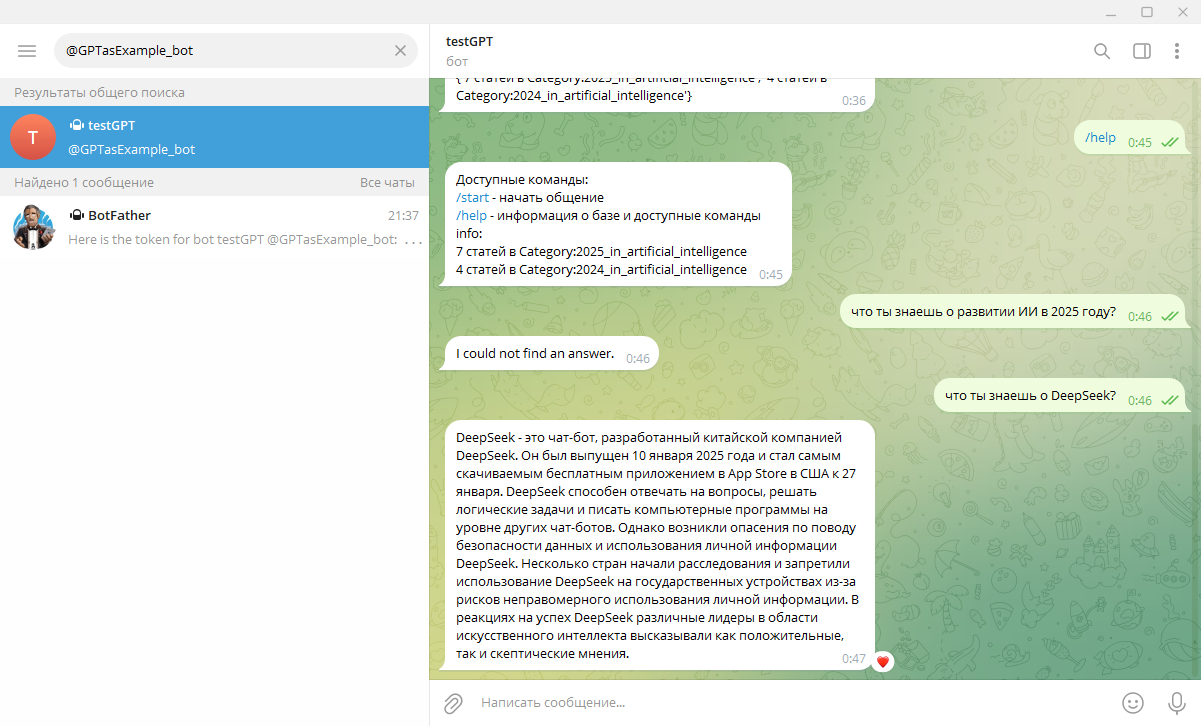

При запросе без использования дополнительной базы через сервис VseGPT

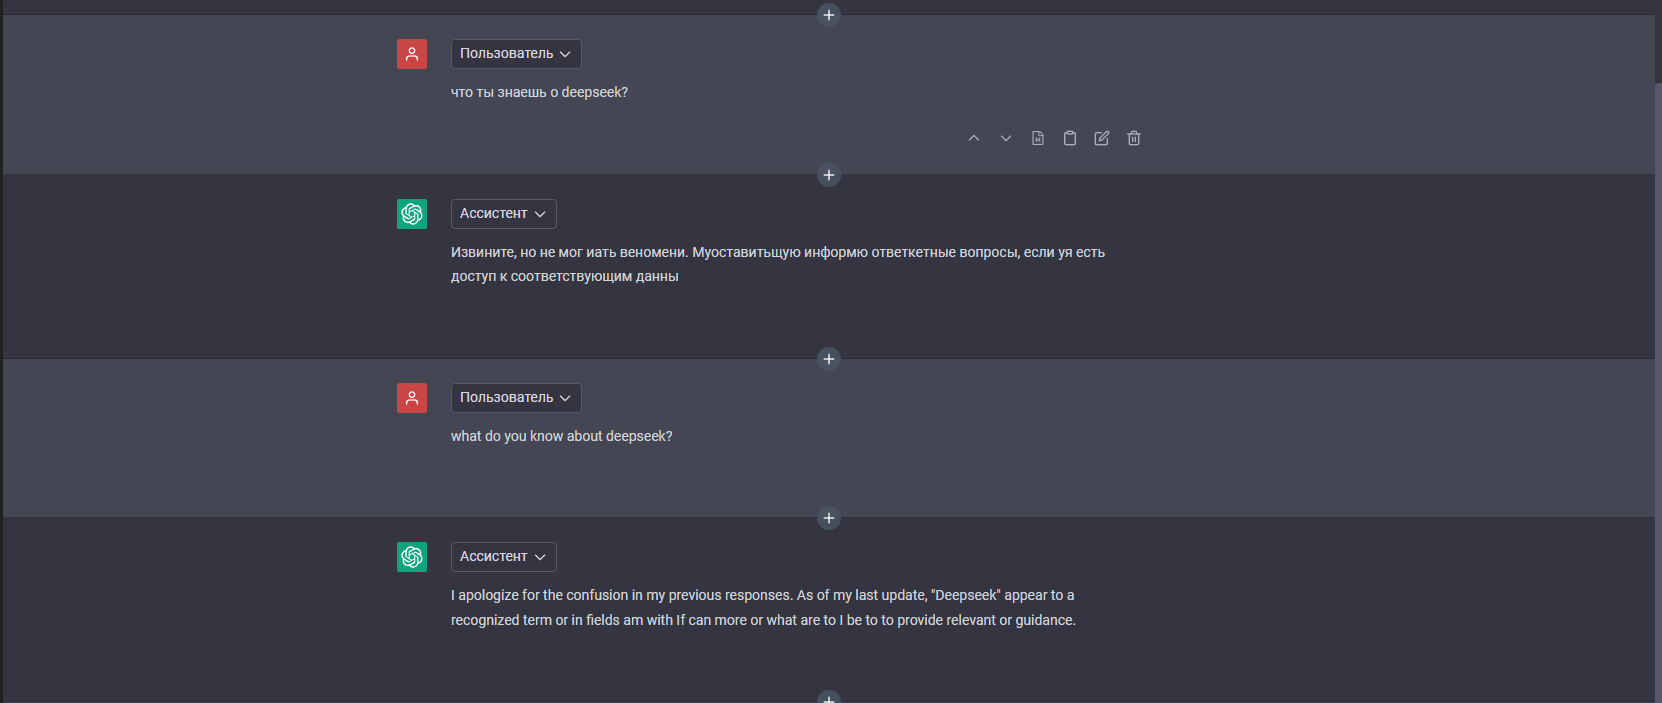